In [1]:
import copy
import glob
import numpy as np
import os
import pandas as pd
import pickle
import scipy
import scipy.stats
import tqdm
import warnings

In [2]:
import yt
import trident
import unyt

In [3]:
import kalepy as kale

In [4]:
import trove
import verdict

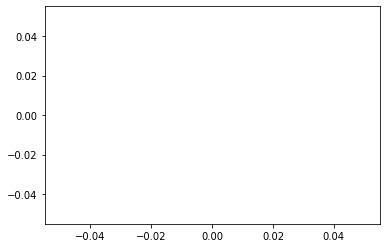

In [5]:
import matplotlib
import matplotlib.pyplot as plt
# # Currently need to call this to get matplotlib selected style to load...
plt.plot()
matplotlib.style.use( '/Users/zhafen/repos/clean-bold/clean-bold-mnras.mplstyle' )
import palettable
import matplotlib.patheffects as path_effects
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [6]:
import helpers

# Parameters

In [7]:
variations = [ 
    'original',
    'high-z',
]

In [8]:
params = {
    # Analysis 
    'prop_keys': [ 'vlos', 'T', 'nH', 'Z' ],
    'vel_prop_keys': [ 'vlos', 'T', 'nH', 'Z', 'NHI' ],
    '1D_dist_estimation': 'kde',
    '1D_dist_estimation_data': 'histogram',
    '2D_dist_estimation': 'histogram',
    'export_data_for_proposal': False,
    'f_enclosed': [ 0.5, 0.68, 0.75, 0.9, 0.99, 0.997 ],
    
    # Plotting Choices
    'smooth_2D_dist': 0.5,
    'upsample_2D_dist': 3,
    '2D_dist_data_display': 'histogram',
    '2D_dist_logscale': True,
    'contour_levels': [ 90, 50 ],
    'contour_linewidths': [ 1, 3 ],
    'show_plots_in_nb': False,
}

## Analysis

## Plotting

In [9]:
variation_plotting_params = {
    'original': {
        'color': helpers.blinded_color,
        'label': 'estimated',
        'offset': -0.2,
    },
    'high-z': {
        'color': helpers.revised_color,
        'label': 'revised',
        'offset': 0.2,
    },
}

In [10]:
min_column = 10.**12.5
min_column_method = 'per pixel'

In [11]:
correlation_markers = {
    'one-sided': '^',
    'log one-sided': '^',
    'two-sided': 'D',
    'linear': 'o',
    'log': 'o',
}
correlation_sizes = {
    'one-sided': 100,
    'log one-sided': 100,
    'two-sided': 80,
    'linear': 100,
    'log': 100,
}
correlations_plotted = [ 'linear', 'log' ]

In [12]:
mosaic = [
    [ 'vlos', 'legend', '.', '.' ],
    [ 'T_vlos', 'T', '.', '.' ],
    [ 'nH_vlos', 'nH_T', 'nH', '.' ],
    [ 'Z_vlos', 'Z_T', 'Z_nH', 'Z', ],
]
velocity_mosaic = [
    [ 'nH_vlos', 'vlos', ],
    [ 'Z_vlos', 'T_vlos', ],
]
mosaic_dist = [ [ 'vlos', 'Z' ], [ 'T', 'nH' ] ]

In [13]:
cmap = palettable.cartocolors.qualitative.Safe_10.mpl_colors[2:]
cmap_alt = palettable.cartocolors.qualitative.Pastel_10.mpl_colors
corr_cmap = palettable.cartocolors.diverging.Temps_2_r.mpl_colormap

In [14]:
corr_norm = matplotlib.colors.Normalize( vmin=0, vmax=1 )

In [15]:
def one_color_linear_cmap( color, name, f_white=0.95, f_saturated=1.0, ):
    '''A function that turns a single color into linear colormap that
    goes from a color that is whiter than the original color to a color
    that is more saturated than the original color.
    '''
    
    color_hsv = matplotlib.colors.rgb_to_hsv( color )
    start_color_hsv = copy.copy( color_hsv )
    
    start_color_hsv = copy.copy( color_hsv )
    start_color_hsv[1] -= f_white * start_color_hsv[1]
    start_color_hsv[2] += f_white * ( 1. - start_color_hsv[2] )
    start_color = matplotlib.colors.hsv_to_rgb( start_color_hsv )
    
    end_color_hsv = copy.copy( color_hsv )
    end_color_hsv[1] += f_saturated * ( 1. - end_color_hsv[1] )
    end_color = matplotlib.colors.hsv_to_rgb( end_color_hsv )
    
    return matplotlib.colors.LinearSegmentedColormap.from_list( name, [ start_color, end_color ] )

## Process analysis parameteres

In [16]:
# Load parameters
pms = {}
for variation in variations:
    pm = trove.link_params_to_config(
        '/Users/zhafen/analysis/cgm_modeling_challenge/sample2.trove',
        script_id = 'nb.2',
        variation = variation,
        global_variation = '',
        **params
    )
    pms[variation] = pm
pm = list( pms.values() )[0]

# Load Data

In [17]:
# correlations_fp = os.path.join( pm['polished_data_dir'], 'correlation_coefficients.h5' )
# correlations_all = verdict.Dict.from_hdf5( correlations_fp )

In [18]:
absorption_properties_fp = os.path.join( pm['polished_data_dir'], 'absorption_system_properties.h5' )
absorption_properties = verdict.Dict.from_hdf5( absorption_properties_fp, )

In [19]:
sls = list( absorption_properties[pm['public_label']].keys() )
n_sls = len( sls )
xs = np.linspace( -0.5, 0.5, n_sls ) / 2

# Data Validation

There was a mix-up in sightline numbers, so this checks that everything is good now.

In [20]:
ray_data_dir = os.path.join( pm['data_dir'], 'rays' )
coords_ray = {
    'x': [],
    'y': [],
}
coords_id = {
    'x': [],
    'y': [],
}
used_sls = []
for identifier, used_sl in helpers.identifiers_to_slnums.items():
    used_sl = int( used_sl )
    used_sls.append( used_sl )
    
    ray_fp = os.path.join( ray_data_dir, 'ray_{:03d}.h5'.format( used_sl ) )
    ray_data, ray_attrs = verdict.Dict.from_hdf5( ray_fp )
    coords_ray['x'].append( ray_data['grid']['x'][0] )
    coords_ray['y'].append( ray_data['grid']['y'][0] )
    
    identifier_split = identifier.split( '_' )
    coords_id['x'].append( float( identifier_split[1] ) )
    coords_id['y'].append( float( identifier_split[2] ) )
    
coords_ray['x'] = np.array( coords_ray['x'] )
coords_ray['y'] = np.array( coords_ray['y'] )
coords_id['x'] = np.array( coords_id['x'] )
coords_id['y'] = np.array( coords_id['y'] )

In [21]:
rng = np.random.default_rng()

Text(0, 0.5, 'ray coordinates / identifier coordinates')

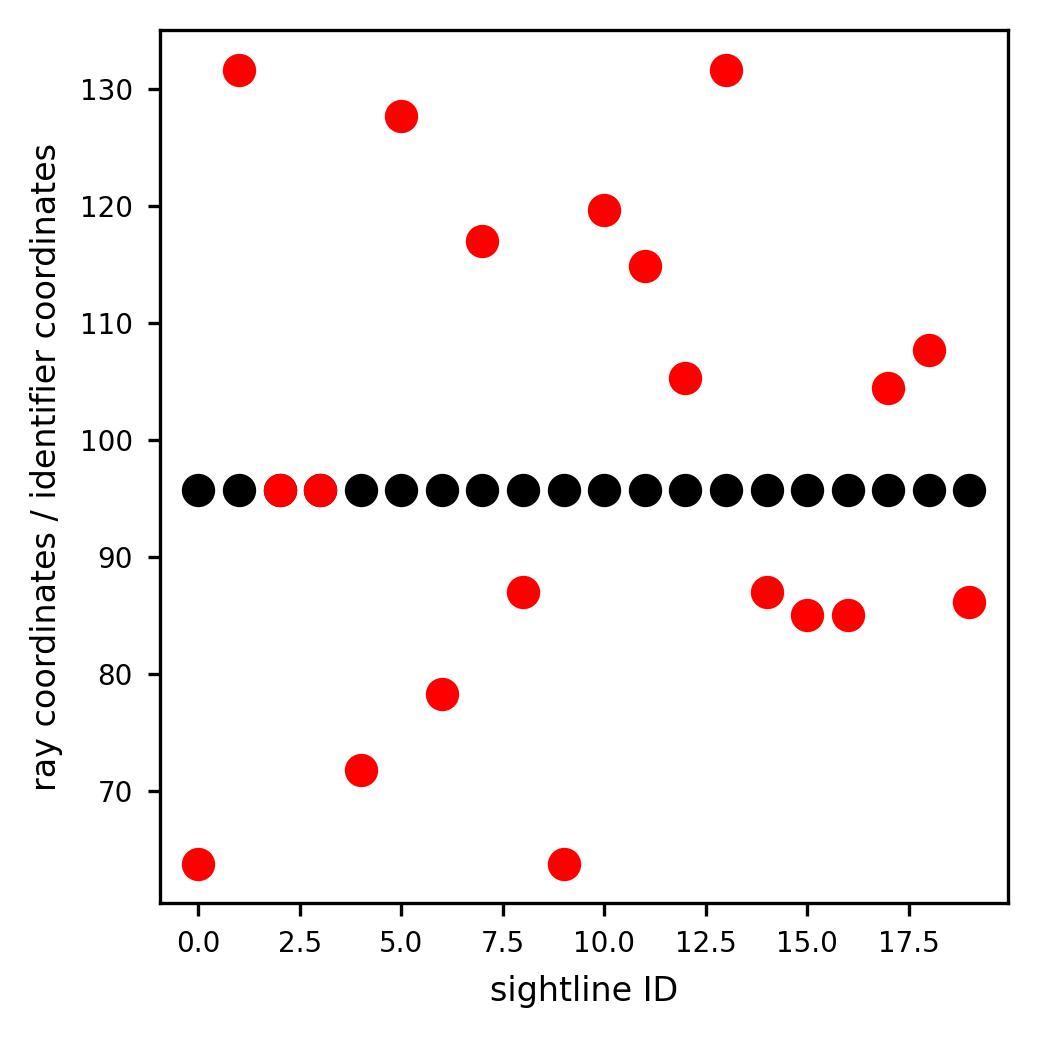

In [22]:
coord_axis = 'y'

fig = plt.figure()
ax = plt.gca()

ax.scatter(
    used_sls,
    coords_ray[coord_axis] / coords_id[coord_axis],
    color = 'k',
)

ax.scatter(
    used_sls,
    rng.permuted( coords_ray[coord_axis] ) / coords_id[coord_axis],
    color = 'r',
)

ax.set_xlabel( 'sightline ID' )
ax.set_ylabel( 'ray coordinates / identifier coordinates' )

If the identifiers are set up correctly then the data coordinates should be proportional to the identifier coordinates. Black is what we have, red is shuffled to show the magnitude of difference available.

# Images

## Remap colormap

In [23]:
# New, preferred colormap
cmap_new_colors = {
    'density': palettable.cubehelix.classic_16.mpl_colors,
    'metallicity': palettable.matplotlib.Viridis_13.mpl_colors, # + [ [ 1., 1., 1. ], ] * 3,
    'velocity': palettable.scientific.diverging.Vik_20_r.mpl_colors,
    'temperature': palettable.matplotlib.Plasma_13.mpl_colors, # + [ [ 1., 1., 1. ], ] * 3,
}

In [24]:
# Setup filepaths
image_fps = glob.glob( os.path.join( pm['code_dir'], 'figures', 'sample2', 'rereprojectionmapsofsightlines', '*', ) )

In [25]:
colorbar_loc = helpers.colorbar_loc

img_areas = helpers.img_areas

grid_coords = helpers.grid_coords
        
coords_first_dash_all = helpers.coords_first_dash_all
coords_second_dash_all = helpers.coords_second_dash_all

In [30]:
for i, image_fp in enumerate( tqdm.tqdm( image_fps ) ):
        
    image_fn = os.path.split( image_fp )[-1]
    projection_type = image_fn.split( '_' )[0]

    img_old = plt.imread( image_fp ).astype( float ) / 255.
    # If alpha isn't stored, put it in as constant
    if img_old.shape[2] < 4:
         img_old = np.pad( img_old, ( (0,0), (0,0), (0,1) ), constant_values=1. )

    # Get the old colorbar
    cbar_old = img_old[colorbar_loc[0][1]:colorbar_loc[1][1],colorbar_loc[0][0]:colorbar_loc[1][0]][::-1]

    # Smooth, in case artifacts were introduced
    cbar_old = np.mean( cbar_old, axis=1 )
    cbar_old = scipy.signal.savgol_filter( cbar_old, 51, 1, axis=0 )
    cbar_old[cbar_old>1.] = 1.
    cbar_old[cbar_old<0.] = 0.
    
    # Get values for interpolation
    cbar_values_old = np.arange( cbar_old.shape[0], dtype=float )
    cbar_values_old /= cbar_values_old.max()

    # Interpolate to extract input values
    color_interp_fn = scipy.interpolate.NearestNDInterpolator( cbar_old, cbar_values_old, )

    # Revise the map to give more room for whitespace    
    cmap_new_revised_colors = cmap_new_colors[projection_type]
    cmap_new_revised = matplotlib.colors.LinearSegmentedColormap.from_list( projection_type, cmap_new_revised_colors )    
    
    img_new = copy.copy( img_old )
    for j, area_coords in enumerate( [ colorbar_loc, ] + img_areas ):
        
        img_area = img_old[area_coords[0][1]:area_coords[1][1],area_coords[0][0]:area_coords[1][0]]
        
        img_area_values = color_interp_fn( img_area )

        # Apply new colormap
        img_area_new = cmap_new_revised( img_area_values )
        
        # # Find where there's BW values, and keep those
        # atol = 0.2
        # white = np.array([ 1., 1., 1., 1. ])
        # black = np.array([ 0., 0., 0., 1. ])
        # specific_colors = [ np.array([ 1., 1., 1., 1. ]), ] # np.array([0., 0., 0., 1.]) ]
        # is_white = np.where( img_area.sum( axis=-1 ) > white.sum() - atol )
        # img_area_new[is_white] = white
        # is_black = np.where( img_area.sum( axis=-1 ) < black.sum() + atol )
        # img_area_new[is_black] = black
        
        # Draw new lines
        if j > 0:
            
            # Gridlines
            grid_xs = grid_coords[j-1][0]
            for left_side, width in grid_xs:
                left_side_actual = left_side - area_coords[0][0]
                img_area_new[:,left_side_actual:left_side_actual+width,:] = 1.
            grid_ys = grid_coords[j-1][1]
            for top_side, width in grid_ys:
                top_side_actual = top_side - area_coords[0][1]
                img_area_new[top_side_actual:top_side_actual+width,:,:] = 1.
                
            # Dashed line
            coords_first_dash = copy.copy( coords_first_dash_all[j-1] )
            coords_second_dash = copy.copy( coords_second_dash_all[j-1] )

            # Put in frame of area
            coords_first_dash -= np.array( area_coords[0] )
            coords_second_dash -= np.array( area_coords[0] )

            dash_width = coords_second_dash[1][0] - coords_second_dash[0][0]
            dash_height = coords_second_dash[1][1] - coords_second_dash[0][1]
            dash_separation = coords_second_dash[0][1] - coords_first_dash[1][1]

            # First dash
            ( left, top ), ( right, bottom ) = coords_first_dash
            img_area_new[top:bottom,left:right] = 1.

            # Rest of the dashes
            ( left, top ), ( right, bottom ) = coords_second_dash
            while True:
                if bottom > area_coords[1][1]:
                    img_area_new[top:area_coords[1][1],left:right] = 1.
                    break

                img_area_new[top:bottom,left:right] = 1.

                top += dash_height + dash_separation
                bottom += dash_height + dash_separation

            # Below are failed efforts to calculate grid locations automatically
#             grid_xs = np.arange( grid_cell_dim[0], img_area.shape[0], grid_cell_dim[0] + pixel_width_grid )
#             grid_ys = np.arange( grid_cell_dim[1], img_area.shape[1], grid_cell_dim[1] + pixel_width_grid )
#             # for ii, grid_ind in enumerate( grid_xs ):
#             #     img_area_new[:,grid_ind:grid_ind+pixel_width_grid,:] = 1.
#             offset = 0
#             sum_std_typical = np.std( img_area.sum( axis=-1 ) )
#             for ii, grid_ind in enumerate( grid_ys ):
#                 grid_ind += offset
#                 sums_gridline = img_area[grid_ind:grid_ind+pixel_width_grid,:,:].sum( axis=-1 )
#                 if np.std( sums_gridline ) > 0.5 * sum_std_typical:
#                     grid_ind += 1
#                     offset += 1
#                 img_area_new[grid_ind:grid_ind+pixel_width_grid,:,:] = 1.

#             # We will assume the rows and columns with low variance in the sums are the gridlines.
#             threshold_factor = 1.
#             stds_x = sums_area.std( axis=1 )
#             std_threshold = np.mean( stds_x ) - threshold_factor * np.std( stds_x )
#             grid_inds_x = np.where( stds_x < std_threshold )[0]
#             img_area_new[:,grid_inds_x,:] = 1.
#             stds_y = sums_area.std( axis=0 )
#             std_threshold = np.mean( stds_y ) - threshold_factor * np.std( stds_y )
#             grid_inds_y = np.where( stds_y < std_threshold )[0]
#             img_area_new[grid_inds_y,:,:] = 1.

#             # Sufficiently white rows or columns will be completely whitened
#             threshold = 3.
#             means_x = np.mean( sums_area, axis=1 )
#             grid_inds_x = np.where( means_x > threshold )[0]
#             img_area_new[:,grid_inds_x,:] = 1.
#             means_y = np.mean( sums_area, axis=0 )
#             grid_inds_y = np.where( means_y > threshold )[0]
#             img_area_new[grid_inds_y,:,:] = 1.
        
        img_new[area_coords[0][1]:area_coords[1][1],area_coords[0][0]:area_coords[1][0],:] = img_area_new
        
    # Crop
    img_new = img_new[helpers.crop[0][1]:helpers.crop[1][1],helpers.crop[0][0]:helpers.crop[1][0],:]


    # Save
    output_fp = os.path.join( pm['figure_dir'], 'projections', image_fn )
    plt.imsave( output_fp, img_new, )

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:21<00:00,  3.68it/s]


(-0.5, 1180.5, 560.5, -0.5)

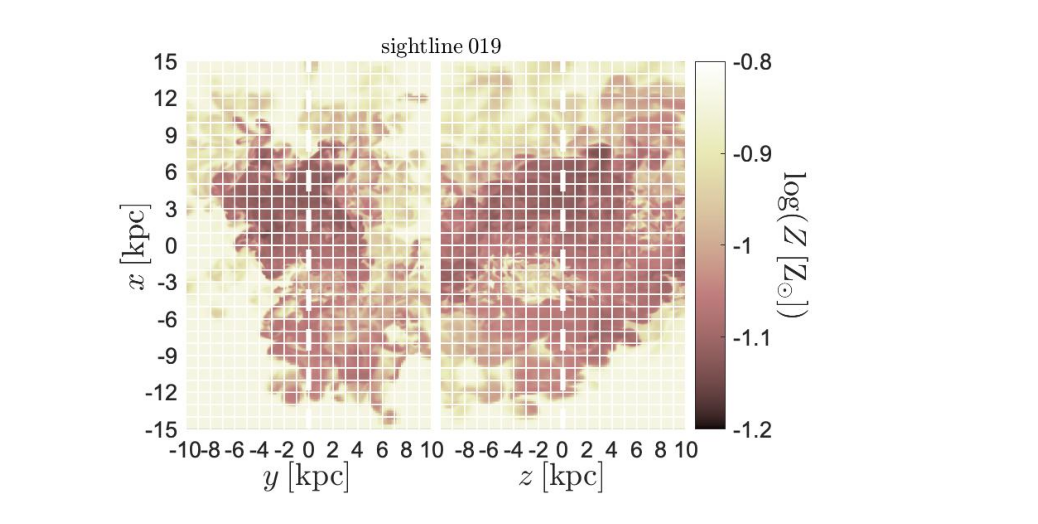

In [27]:
fig = plt.figure()
ax = plt.gca()
ax.imshow( img_old )

ax.axis( 'off' )

(-0.5, 837.5, 553.5, -0.5)

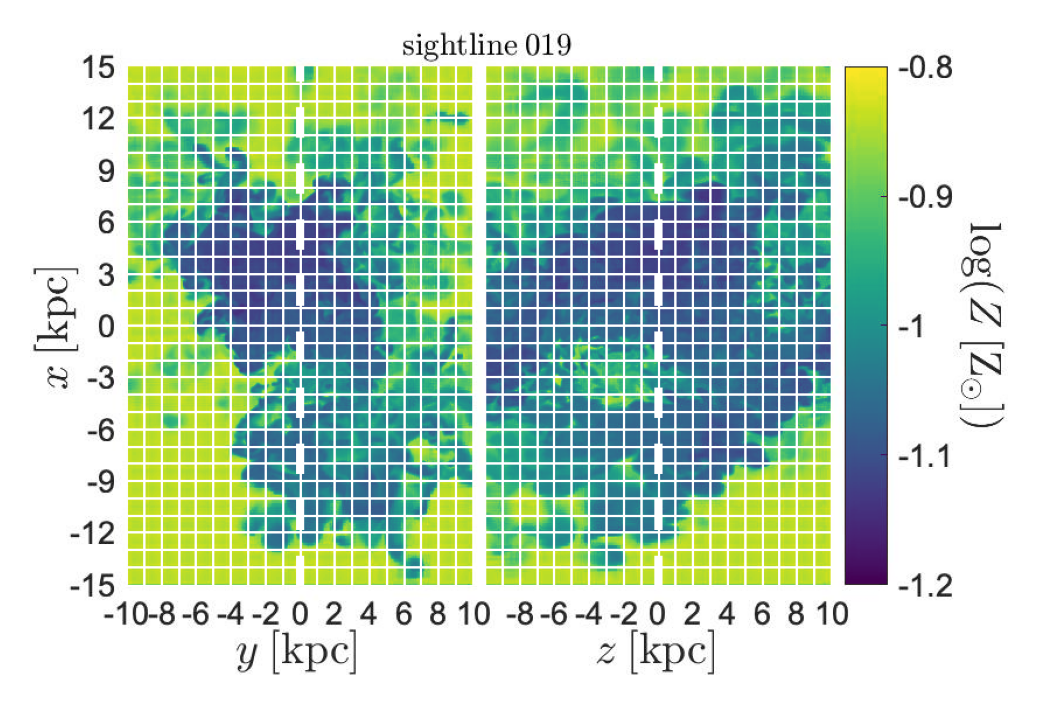

In [29]:
fig = plt.figure()
ax = plt.gca()

ax.imshow( img_new )

ax.axis( 'off' )

# Metrics

## Calculate

In [ ]:
averages = verdict.Dict({})
distances_between = verdict.Dict({})
percentiles = verdict.Dict({})
columns = verdict.Dict({})
for i, sl in enumerate( sls ):

    for prop_key in absorption_properties[pm['public_label']][sl]['source']['1D distributions']['centers'].keys():

        for fraction in pm['f_enclosed']:
            
            onesided_fraction = ( 1 - fraction ) / 2.
            percentile_str = helpers.percentile_str_fn( fraction )
            lower_percentile_str = helpers.percentile_str_fn( onesided_fraction )
            upper_percentile_str = helpers.percentile_str_fn( 1. - onesided_fraction )
            
            for variation, pm in pms.items():
                
                # Get data distributions
                centers_data = absorption_properties[pm['public_label']][sl]['source']['1D distributions']['centers'][prop_key]
                if helpers.logscale[prop_key]:
                    centers_data = np.log10( centers_data )
                dist_data = absorption_properties[pm['public_label']][sl]['source']['1D distributions']['distributions'][prop_key]
                dist_data_sum = dist_data.sum()
                cdf_data = np.cumsum( dist_data ) / dist_data_sum
                interp_data = scipy.interpolate.interp1d( cdf_data, centers_data )

                # Calculate data average
                avg_data = interp_data( 0.5 )
                averages.setitem( pm['public_label'], avg_data, 'source', prop_key, sl )

                # Calculate data percentiles
                try:
                    lower = interp_data( onesided_fraction )
                except ValueError:
                    lower = centers_data[0]
                try:
                    upper = interp_data( 1. - onesided_fraction )
                except ValueError:
                    upper = centers_data[-1]
                interval_data = np.array([ lower, upper ])
                width_data = interval_data[1] - interval_data[0]
                percentiles.setitem( pm['public_label'], interval_data, 'source', prop_key, 'interval', percentile_str, sl )
                percentiles.setitem( pm['public_label'], width_data, 'source', prop_key, 'width', percentile_str, sl )
                percentiles.setitem( pm['public_label'], lower, 'source', prop_key, 'percentile', lower_percentile_str, sl )
                percentiles.setitem( pm['public_label'], upper, 'source', prop_key, 'percentile', upper_percentile_str, sl )
                
                # Calculate integrated column for data
                column_data = np.trapz( dist_data, centers_data )
                y_min_data = dist_data[dist_data > 0].min()
                column_min_data = y_min_data * ( centers_data[-1] - centers_data[0] )
                columns.setitem( pm['public_label'], column_data, 'source', 'total column', prop_key, sl )
                columns.setitem( pm['public_label'], column_min_data, 'source', 'minimum column', prop_key, sl )
                
                # Skip if no data
                if not ( prop_key in absorption_properties[pm['public_label']][sl]['estimated']['1D distributions']['centers'] ):
                    continue

                # Get modeled distributions
                centers_estimated = absorption_properties[pm['public_label']][sl]['estimated']['1D distributions']['centers'][prop_key]
                if helpers.logscale[prop_key]:
                    centers_estimated = np.log10( centers_estimated )
                dist_estimated = absorption_properties[pm['public_label']][sl]['estimated']['1D distributions']['combined distributions'][prop_key]
                dist_estimated_sum = dist_estimated.sum()
                cdf_estimated = np.cumsum( dist_estimated ) / dist_estimated_sum
                interp_estimated = scipy.interpolate.interp1d( cdf_estimated, centers_estimated )
                
                # Calculate MLE and averages
                x_max = centers_estimated[np.argmax( dist_estimated )]
                x_avg = interp_estimated( 0.5 )
                averages.setitem( pm['public_label'], x_max, 'estimated', 'MLE', prop_key, sl )
                averages.setitem( pm['public_label'], x_avg, 'estimated', 'average', prop_key, sl )

                # Calculate parameter estimation percentiles
                try:
                    lower = interp_estimated( onesided_fraction )
                except ValueError:
                    lower = centers_estimated[0]
                try:
                    upper = interp_estimated( 1. - onesided_fraction )
                except ValueError:
                    lower = centers_estimated[-1]
                interval_data = np.array([ lower, upper ])
                width_data = interval_data[1] - interval_data[0]
                percentiles.setitem( pm['public_label'], interval_data, 'estimated', 'combined', prop_key, 'interval', percentile_str, sl )
                percentiles.setitem( pm['public_label'], width_data, 'estimated', 'combined', prop_key, 'width', percentile_str, sl )
                percentiles.setitem( pm['public_label'], lower, 'estimated', 'combined', prop_key, 'percentile', lower_percentile_str, sl )
                percentiles.setitem( pm['public_label'], upper, 'estimated', 'combined', prop_key, 'percentile', upper_percentile_str, sl )

                # Calculate necessary width
                width_necessary = np.max( np.abs( interval_data - x_max ) )
                width_between_peaks = np.abs( avg_data - x_max )
                distances_between.setitem( pm['public_label'], width_necessary, prop_key, 'distance_to_enclose', str( fraction ), sl )
                distances_between.setitem( pm['public_label'], width_between_peaks, prop_key, 'distance_to_avg', sl )
                
                # Calculate integrated column for estimation
                column_estimated = np.trapz( dist_estimated, centers_estimated )
                columns.setitem( pm['public_label'], column_estimated, 'estimated', 'combined column', prop_key, sl )
                
                # Some of the calculations for individual components
                comp_dists = absorption_properties[pm['public_label']][sl]['estimated']['1D distributions']['individual distributions']
                for comp_key, comp in comp_dists.items():
                    dist_comp = comp[prop_key]
                    
                    # Percentiles
                    dist_comp_sum = dist_comp.sum()
                    cdf_comp = np.cumsum( dist_comp ) / dist_comp_sum
                    interp_comp = scipy.interpolate.interp1d( cdf_comp, centers_estimated )
                    try:
                        lower = interp_comp( onesided_fraction )
                    except ValueError:
                        lower = centers_estimated[0]
                    try:
                        upper = interp_comp( 1. - onesided_fraction )
                    except ValueError:
                        lower = centers_estimated[-1]
                    interval_data = np.array([ lower, upper ])
                    width_data = interval_data[1] - interval_data[0]
                    percentiles.setitem( pm['public_label'], interval_data, 'estimated', 'individual', sl, prop_key, 'interval', percentile_str, comp_key )
                    percentiles.setitem( pm['public_label'], width_data, 'estimated', 'individual', sl, prop_key, 'width', percentile_str, comp_key )
                    percentiles.setitem( pm['public_label'], lower, 'estimated', 'individual', sl, prop_key, 'percentile', lower_percentile_str, comp_key )
                    percentiles.setitem( pm['public_label'], upper, 'estimated', 'individual', sl, prop_key, 'percentile', upper_percentile_str, comp_key )
                    
                    # Integrated column
                    column_comp = np.trapz( dist_comp, centers_estimated )
                    columns.setitem( pm['public_label'], column_comp, 'estimated', 'individual columns', sl, comp_key, prop_key )
                    
                    # MLE
                    mle_comp = centers_estimated[dist_comp.argmax()]
                    averages.setitem( pm['public_label'], mle_comp, 'estimated', 'MLE individual', prop_key, sl, comp_key )

In [ ]:
sl

In [ ]:
# Calculate fraction enclosed
f_estimated_to_enclose_f_data = verdict.Dict({})
f_data_enclosed_by_f_estimated = verdict.Dict({})
for i, sl in enumerate( sls ):

    for prop_key in absorption_properties[pm['public_label']][sl]['source']['1D distributions']['centers'].keys():
        
        if not ( prop_key in absorption_properties[pm['public_label']][sl]['estimated']['1D distributions']['centers'] ):
            continue
        
        for variation, pm in pms.items():

            # Get data distributions
            centers_data = absorption_properties[pm['public_label']][sl]['source']['1D distributions']['centers'][prop_key]
            dist_data = absorption_properties[pm['public_label']][sl]['source']['1D distributions']['distributions'][prop_key]
            dist_data_sum = dist_data.sum()

            # Get modeled distributions
            centers_estimated = absorption_properties[pm['public_label']][sl]['estimated']['1D distributions']['centers'][prop_key]
            bins_estimated = np.full( centers_estimated.shape, np.nan )
            bin_widths = np.diff( centers_estimated )
            bins_estimated[0:centers_estimated.size-1] = centers_estimated[:-1] - bin_widths / 2.
            bins_estimated[centers_estimated.size-1] = centers_estimated[-1] + bin_widths[-1] / 2.
            dist_estimated = absorption_properties[pm['public_label']][sl]['estimated']['1D distributions']['combined distributions'][prop_key]
            dist_estimated_sum = dist_estimated.sum()
            max_ind_estimated = dist_estimated.argmax()

            # Calculate fraction included arrays
            j = 0
            f_included_data = []
            f_included_estimated = []
            while True:

                # Get range to include
                left = max_ind_estimated - j
                right = max_ind_estimated + j + 1

                # Check if looping is done
                left_in_bounds = left >= 0
                right_in_bounds = right < centers_estimated.size
                continue_looping = left_in_bounds or right_in_bounds
                if not continue_looping:
                    break
                    
                if not left_in_bounds:
                    left = 0
                if not right_in_bounds:
                    right = centers_estimated.size - 1

                # Get fraction included
                x_value_left = bins_estimated[left]
                x_value_right = bins_estimated[right]
                is_in_range_data = ( centers_data > x_value_left ) & (centers_data < x_value_right )

                f_included_data.append( dist_data[is_in_range_data].sum() / dist_data_sum )
                f_included_estimated.append( dist_estimated[left:right].sum() / dist_estimated_sum )

                j += 1
            f_included_data = np.array( f_included_data )
            f_included_estimated = np.array( f_included_estimated )
            
            # Extract a summary statistic
            interp_data_estimated = scipy.interpolate.interp1d( f_included_data, f_included_estimated )
            interp_estimated_data = scipy.interpolate.interp1d( f_included_estimated, f_included_data )
            for fraction in pm['f_enclosed']:
                
                ## Fraction needed to enclose
                try:
                    f_to_enclose = interp_data_estimated( fraction )
                    
                    # If a value of 1 is needed, then the distribution doesn't actually enclose the data.
                    if np.isclose( f_to_enclose, 1. ):
                        f_to_enclose = np.nan
                # If above or below the interpolation range
                except ValueError:
                    # If below, that means the fraction was reached with the first cell
                    if fraction <= f_included_data[0]:
                        f_to_enclose = f_included_estimated[0]
                    # If above, then invalid
                    elif fraction >= f_included_data[-1]:
                        f_to_enclose = np.nan
                f_estimated_to_enclose_f_data.setitem( pm['public_label'], f_to_enclose, prop_key, str( fraction ), sl )
                
                ## Fraction enclosed by a fixed value
                try:
                    f_data_enclosed = interp_estimated_data( fraction )
                # If above or below the interpolation range
                except ValueError:
                    # If below the interpolation range, then f_estimated jumps sharply early,
                    # so the enclosed amount is just the first entry in f_included_data
                    if fraction < f_included_estimated[0]:
                        f_data_enclosed = f_included_data[0]
                    # If above the interpolation range, then invalid
                    if fraction >= f_included_estimated[-1]:
                        f_data_enclosed = np.nan
                f_data_enclosed_by_f_estimated.setitem( pm['public_label'], f_data_enclosed, prop_key, str( fraction ), sl )

## Plotting Setup

In [ ]:
def plot_metric( get_ys, fig_tuple=None, y_fn_is_per_component=False, **scatter_kwargs ):
    
    if fig_tuple is None:
        # Setup figure
        panel_width = plt.rcParams['figure.figsize'][0]
        n_rows = len( mosaic_dist )
        n_cols = len( mosaic_dist[0] )
        fig = plt.figure( figsize=(n_cols*panel_width, n_rows*panel_width), facecolor='w' )
        main_ax = plt.gca()
        main_ax.tick_params( left=False, labelleft=False, bottom=False, labelbottom=False )
        for spine in main_ax.spines.values():
            spine.set_visible( False )

        ax_dict = fig.subplot_mosaic(
            mosaic_dist,
            gridspec_kw = { 'hspace': 0.15, 'wspace': 0.12 },
        )
    else:
        fig, main_ax, ax_dict = fig_tuple
    
    # Axes tweaks
    for ax_key, ax in ax_dict.items():

        ax.set_xticks( xs )
        xtick_labels = [ _[-2:] for _ in sls ]
        ax.set_xticklabels( xtick_labels )
        
        # Axes tweaks
        axis_label = helpers.property_labels_no_units[ax_key]
        if helpers.logscale[ax_key]:
            axis_label = 'log' + axis_label

        ax.annotate(
            text = axis_label,
            xy = ( 0, 1 ),
            xycoords = 'axes fraction',
            xytext = ( 5, -5 ),
            textcoords = 'offset points',
            va = 'top',
            ha = 'left',
        )
        
    for variation, pm in pms.items():

        for ax_key, ax in ax_dict.items():
        
            if not y_fn_is_per_component:
                ys = get_ys( variation=variation, prop_key=ax_key )
                if ys is None:
                    continue
                    
                color = helpers.colors_for_variations[pm['variation']]
                fill_color = color
                used_scatter_kwargs = dict(
                    s = 100,
                    edgecolor = color,
                    color = fill_color,
                )
                used_scatter_kwargs.update( scatter_kwargs )

                scatter = ax.scatter(
                    xs,
                    ys,
                    **used_scatter_kwargs
                )

            else:
                ys_comps = get_ys( variation=variation, prop_key=ax_key )
                
                if ys_comps is None:
                    continue
                    
                for i, sl in enumerate( sls ):
                    for comp_key, ys in ys_comps[sl].items():

                        color = helpers.colors_for_variations[pm['variation']]
                        fill_color = color
                        used_scatter_kwargs = dict(
                            s = 100,
                            edgecolor = color,
                            color = fill_color,
                        )
                        used_scatter_kwargs.update( scatter_kwargs )

                        scatter = ax.scatter(
                            xs[i],
                            ys[ax_key],
                            **used_scatter_kwargs
                        )

    
    return fig, main_ax, ax_dict

## Columns

### Source, Other Source

In [ ]:
def get_source_ys( variation, prop_key ):

    pm = pms[variation]

    ys = columns[pm['public_label']]['source']['total column'][prop_key].array()
    return ys

fig, main_ax, ax_dict = plot_metric( get_source_ys, color='k', linewidth=2, )

for ax_key, ax in ax_dict.items():
    ax.set_yscale( 'log' )
    
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel( r'$N_{\rm{HI}}$ [cm$^{-2}$]' )

Different total columns because of different UVBs, but reassuringly the total column is the same regardless of the property the integration is done over.

### Source, Estimated

In [ ]:
def get_source_ys( variation, prop_key ):

    pm = pms[variation]

    ys = columns[pm['public_label']]['source']['total column'][prop_key].array()
    return ys

def get_estimated_ys( variation, prop_key ):

    pm = pms[variation]

    ys = columns[pm['public_label']]['estimated']['combined column'][prop_key].array()
    return ys

fig, main_ax, ax_dict = plot_metric( get_source_ys, color='k', linewidth=2, )

fig, main_ax, ax_dict = plot_metric( get_estimated_ys, (fig, main_ax, ax_dict) )

for ax_key, ax in ax_dict.items():
    ax.set_yscale( 'log' )
    
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel( r'$N_{\rm{HI}}$ [cm$^{-2}$]' )

### Source, Estimated per Component

In [ ]:
def get_source_ys( variation, prop_key ):

    pm = pms[variation]

    ys = columns[pm['public_label']]['source']['total column'][prop_key].array()
    return ys

def get_source_ys_min( variation, prop_key ):

    pm = pms[variation]

    ys = columns[pm['public_label']]['source']['minimum column'][prop_key].array()
    return ys

def get_estimated_ys_comp( variation, prop_key ):

    pm = pms[variation]
    
    ys_comps = columns[pm['public_label']]['estimated']['individual columns']
    return ys_comps

fig, main_ax, ax_dict = plot_metric( get_source_ys, color='k', linewidth=2, marker='v' )

fig, main_ax, ax_dict = plot_metric( get_source_ys_min, (fig, main_ax, ax_dict), color='k', linewidth=2, marker='^' )

fig, main_ax, ax_dict = plot_metric( get_estimated_ys_comp, (fig, main_ax, ax_dict), y_fn_is_per_component=True, s=50, )

for ax_key, ax in ax_dict.items():
    ax.set_yscale( 'log' )
    
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel( r'$N_{\rm{HI}}$ [cm$^{-2}$]' )

The arrows indicate the range for which components are of interest, e.g. enough to plot.
Bottom arrow shows column below which dist drops to zero.
Top arrow shows total integrated column.

## MLEs and Average Values

### Straight-up values

In [ ]:
def get_estimated_ys( variation, prop_key ):

    pm = pms[variation]

    mle = averages[pm['public_label']]['estimated']['MLE'][prop_key].array()
    return mle

fig, main_ax, ax_dict = plot_metric( get_estimated_ys )

def get_source_ys( variation, prop_key ):
    
    if variation != 'original':
        return None

    pm = pms[variation]

    avg = averages[pm['public_label']]['source'][prop_key].array()
    return avg

fig, main_ax, ax_dict = plot_metric( get_source_ys, ( fig, main_ax, ax_dict ), marker='x', color='k', )

# Axes tweaks
for ax_key, ax in ax_dict.items():         
    ylims = helpers.lims[ax_key]
    if helpers.logscale[ax_key]:
        ylims = np.log10( ylims )

    ax.set_ylim( ylims )

main_ax.set_xlabel( 'sightline ID', labelpad=30 )
main_ax.set_ylabel( r'$x_{\rm MLE}$', labelpad=40 )

### Difference between values

In [ ]:
def get_ys( variation, prop_key ):

    pm = pms[variation]

    d_between = distances_between[pm['public_label']][prop_key]['distance_to_avg'].array()
    return d_between

fig, main_ax, ax_dict = plot_metric( get_ys )

main_ax.set_xlabel( 'sightline ID', labelpad=30 )
main_ax.set_ylabel( r'$\left| x_{\rm MLE} - \langle x \rangle \right|$', labelpad=30 )

## Distribution Widths

### Scaled by error

In [ ]:
for fraction in pm['f_enclosed']:
    
    def get_widths( variation, prop_key ):
        
        pm = pms[variation]
        
        percentile = percentiles[pm['public_label']]['estimated']['combined'][prop_key]['width'][str(100.*fraction)].array()
        d_between = distances_between[pm['public_label']][prop_key]['distance_to_avg'].array()
        
        if helpers.logscale[prop_key]:
            return percentile - d_between
        else:
            return percentile / d_between
    
    fig, main_ax, ax_dict = plot_metric( get_widths )
    
    for ax_key, ax in ax_dict.items():
        
        hline = 1
        
        if helpers.logscale[ax_key]:
            hline = np.log10( hline )
            
        ax.axhline( hline, color='0.5', )

    main_ax.set_xlabel( 'sightline ID', labelpad=30 )
    main_ax.set_ylabel( '{}'.format( int( fraction * 100 ) ) + r'th percentile / $\left| x_{\rm MLE} - \langle x \rangle \right|$', labelpad=60 )

### Scaled by distance to enclose

In [ ]:
for fraction in pm['f_enclosed']:
    
    def get_widths( variation, prop_key ):
        
        pm = pms[variation]
        
        percentile = percentiles[pm['public_label']]['estimated']['combined'][prop_key]['width'][str(100.*fraction)].array()
        d_between = distances_between[pm['public_label']][prop_key]['distance_to_enclose'][str(fraction)].array()
        
        if helpers.logscale[prop_key]:
            return percentile - d_between
        else:
            return percentile / d_between
    
    fig, main_ax, ax_dict = plot_metric( get_widths )
    
    for ax_key, ax in ax_dict.items():
        
        hline = 1
        
        if helpers.logscale[ax_key]:
            hline = np.log10( hline )
            
        ax.axhline( hline, color='0.5', )

    main_ax.set_xlabel( 'sightline ID', labelpad=30 )
    main_ax.set_ylabel( '{}'.format( int( fraction * 100 ) ) + r'th percentile / $\left| x_{\rm MLE} - x_{' + '{}'.format( int( fraction * 100 ) ) + r'} \right|$', labelpad=60 )

## Fraction enclosed

### % of likelihood to enclose

In [ ]:
for fraction in pm['f_enclosed']:
    
    def get_ys( variation, prop_key ):
        
        pm = pms[variation]
        
        ys = f_estimated_to_enclose_f_data[pm['public_label']][prop_key][str(fraction)].array() * 100
        
        return ys
    
    fig, main_ax, ax_dict = plot_metric( get_ys )
    
    for ax_key, ax in ax_dict.items():
        
        ax.set_ylim( 0, 100 )
        
        hline = fraction * 100
            
        ax.axhline( hline, color='0.5', )

    main_ax.set_xlabel( 'sightline ID', labelpad=30 )
    main_ax.set_ylabel( '% of likelihood to enclose {}% of the data'.format( int( fraction * 100 ) ), labelpad=60 )

### % of data enclosed

In [ ]:
for fraction in pm['f_enclosed']:
    
    def get_ys( variation, prop_key ):
        
        pm = pms[variation]
        
        ys = f_data_enclosed_by_f_estimated[pm['public_label']][ax_key][str(fraction)].array() * 100
        
        return ys
    
    fig, main_ax, ax_dict = plot_metric( get_ys )
    
    for ax_key, ax in ax_dict.items():
        
        ax.set_ylim( 0, 100 )
        
        hline = fraction * 100
            
        ax.axhline( hline, color='0.5', )

    main_ax.set_xlabel( 'sightline ID', labelpad=30 )
    main_ax.set_ylabel( '% of data enclosed by {}% of the likelihood'.format( int( fraction * 100 ) ), labelpad=30 )


In [ ]:
## Correlation Coefficients

In [ ]:
# # Setup Figure
# n_rows = len( mosaic_dist )
# n_cols = len( mosaic_dist[0] )
# panel_width = plt.rcParams['figure.figsize'][0]
# fig = plt.figure( figsize=(n_cols*panel_width, n_rows*panel_width), facecolor='w' )
# ax_dict = fig.subplot_mosaic(
#     mosaic_dist,
#     gridspec_kw = { 'wspace': 0.7 },
# )
# ax_dict['legend'] = ax_dict['vlos']

# def r_scatter( ax, ys, c_key, color=None, label_tag=None ):
#     c_params = helpers.correlation_coefficients[c_key]
#     if 'logscale' in c_params:
#         if c_params['logscale']:
#             facecolors = 'none'
#     else:
#         facecolors = color
        
#     scatter = ax.scatter(
#         xs,
#         ys,
#         label = '{}, {}'.format( label_tag, c_key ),
#         edgecolors = color,
#         facecolors = facecolors,
#         marker = correlation_markers[c_key],
#         # s = correlation_sizes[c_key],
#         linewidth = 2,
#     )

    
# # Overall
# for variation, pm in pms.items():
    
#     correlations = correlations_all[pm['public_label']]
#     plotting_params = variation_plotting_params[variation]
    
#     # for c_key in correlations_plotted:
#     #     r_scatter(
#     #         ax_dict['all'],
#     #         correlations[c_key]['ndim'].array(),
#     #         c_key,
#     #         color = plotting_params['color'],
#     #     )

#     # Each property
#     for j, x_key in enumerate( tqdm.tqdm( pm['prop_keys'], bar_format=pm['bar_format'] ) ):

#         ax = ax_dict[x_key]

#         for c_key in correlations_plotted:
#             r_scatter(
#                 ax,
#                 correlations[c_key]['matrix'].array()[:,j,j],
#                 c_key,
#                 color = plotting_params['color'],
#                 label_tag = plotting_params['label'],
#             )
    
        
# # Add a legend
# h, l = ax_dict['vlos'].get_legend_handles_labels()
# legend = ax_dict['legend'].legend(
#     h,
#     l,
#     loc = 'lower left',
#     # prop = {'size': 14},
#     ncol = 2,
#     framealpha = 1,
# )
# # ax_dict['legend'].axis( 'off' )
# # ax_dict['legend'].annotate(
# #     text = r'$r = \frac{ \langle {\rm actual } \vert  {\rm found } \rangle }{ \vert {\rm actual} \vert \vert {\rm found } \vert }$',
# #     xy = ( 0, 1 ),
# #     xycoords = 'axes fraction',
# #     xytext = ( 5, -5 ),
# #     textcoords = 'offset points',
# #     ha = 'center',
# #     va = 'top',
# #     fontsize = 18,
# # )
        
# # Cleanup
# for x_key, ax in ax_dict.items():
    
#     if x_key in [ 'legend', 'empty' ]:
#         continue
    
#     subplotspec = ax.get_subplotspec()
    
#     for value in [ -1, 0, 1 ]:
#         ax.axhline(
#             value,
#             color = pm['background_linecolor'],
#             linewidth = 1,
#             zorder = -100,
#         )
        
#     ax.set_ylabel( helpers.correlation_coefficient_property_labels[x_key] )
#     if subplotspec.is_last_row():
#         ax.set_xlabel( 'sightline ID', )
        
#     ax.set_xticks( xs )
#     xtick_labels = [ _[-2:] for _ in correlations[c_key]['ndim'].keys_array() ]
#     ax.set_xticklabels( xtick_labels )
        
#     ax.set_ylim( -0.3, 1.1 )
    
# # Save
# savedir = pm['figure_dir']
# os.makedirs( savedir, exist_ok=True )
# savefile = 'correlations.pdf'
# save_fp = os.path.join( savedir, savefile )
# print( 'Saving figure to {}'.format( save_fp ) )
# plt.savefig( save_fp, bbox_inches='tight' )

# Distribution Comparisons

## 1D Distributions

In [ ]:
panel_length = plt.rcParams['figure.figsize'][0]
n_row = len( mosaic_dist )
n_col = len( mosaic_dist[0] )
figsize = ( panel_length * n_col, panel_length / 2. * n_row )

In [ ]:
# Calculate limits
dNHI_dx_min = verdict.Dict()
if min_column_method == 'per pixel':
    
    sl = sls[0]
    variation = 'high-z'
    pm = pms[variation]

    centers_x_all = absorption_properties[pm['public_label']][sl]['source']['1D distributions']['centers']

    for x_key, centers_x in centers_x_all.items():

        # Get data centers
        centers_x = copy.copy( centers_x )
        if helpers.logscale[x_key]:
            centers_x = np.log10( centers_x )

        dx = ( centers_x[1] - centers_x[0] )

        dNHI_dx_min[x_key] = min_column / dx
                
elif min_column_method == 'per lim':
    for prop_key, lim in helpers.lims.items():
        if helpers.logscale[prop_key]:
            lim = np.log10( lim )
        dNHI_dx_min[prop_key] = min_column / ( lim[1] - lim[0] )

In [ ]:
%%capture
dist_figs = []

for i, sl in enumerate( sls ):

    # Setup figure
    fig = plt.figure( figsize=figsize )
    main_ax = plt.gca()
    main_ax.tick_params( left=False, labelleft=False, bottom=False, labelbottom=False )
    for spine in main_ax.spines.values():
        spine.set_visible( False )

    ax_dict = fig.subplot_mosaic(
        mosaic_dist,
    )

    for ax_key, ax in ax_dict.items():
        
        ax.annotate(
            text = helpers.property_labels_1D( ax_key, pm['weighting'] ),
            xy = ( 0, 1 ),
            xycoords = 'axes fraction',
            xytext = ( 5, -5 ),
            textcoords = 'offset points',
            va = 'top',
            ha = 'left',
        )
        
        xlim = helpers.lims[ax_key]
        if helpers.logscale[ax_key]:
            xlim = np.log10( xlim )

        ax.set_xlim( xlim )

        ax.set_yscale( 'log' )

        ax.set_xlabel( helpers.property_labels[ax_key] )
        
    plot_title = (
        sl +
        '        ' + 
        r'$N_{\rm{H\,I},\,source} = 10^{' +
        '{:.1f}'.format( np.log10( columns[pm['public_label']]['source']['total column']['Z'][sl] ) ) +
        '}$ cm$^{-2}$'
    )
    main_ax.set_title(
        label = plot_title,
        loc = 'left',
        fontsize = 'medium',
    )

    y_maxs = verdict.Dict({})
    for j, prop_key in enumerate( ax_dict.keys() ):

        # Get plot panel
        ax = ax_dict[prop_key]
        subplotspec = ax.get_subplotspec()

        # Get data distributions
        centers_data = absorption_properties[pm['public_label']][sl]['source']['1D distributions']['centers'][prop_key]
        if helpers.logscale[prop_key]:
            centers_data = np.log10( centers_data )
        dist_data = absorption_properties[pm['public_label']][sl]['source']['1D distributions']['distributions'][prop_key]
        y_maxs[prop_key] = [ dist_data.max(), ]
        
        ax.fill_between(
            centers_data,
            dist_data,
            color = 'k',
            step = 'mid',
            label = 'source',
        )
        
        for variation, pm in pms.items():

            if pm['variation'] == 'original':
                continue

            # Modeled distribution
            centers_estimated = absorption_properties[pm['public_label']][sl]['estimated']['1D distributions']['centers'][prop_key]
            if helpers.logscale[prop_key]:
                centers_estimated = np.log10( centers_estimated )
            dist_estimated = absorption_properties[pm['public_label']][sl]['estimated']['1D distributions']['combined distributions'][prop_key]
            comp_dist_estimated = absorption_properties[pm['public_label']][sl]['estimated']['1D distributions']['individual distributions']
            y_maxs[prop_key].append( dist_estimated.max() )
            
            
            # Smooth low contributions
            percentile = percentiles[pm['public_label']]['estimated']['combined'][prop_key]['interval']['99.0'][sl]
            is_tail_low = centers_estimated < percentile[0]
            is_tail_high = centers_estimated > percentile[1]
            is_tail = is_tail_low | is_tail_high
            is_not_tail= np.invert( is_tail )
            dist_plotted = copy.copy( dist_estimated )
            window_length = 3
            if is_tail_low.sum() >= window_length:
                dist_plotted[is_tail_low] = scipy.signal.savgol_filter( dist_plotted[is_tail_low], window_length, 0 )
            if is_tail_high.sum() >= window_length:
                dist_plotted[is_tail_high] = scipy.signal.savgol_filter( dist_plotted[is_tail_high], window_length, 0 ) 
                
            # Skip vlos because the values are well-constrained.
            # We'll just show the individual components.
            if prop_key != 'vlos':
            
                # Truncate low contributions, if desired
                if False:
                    alphas = [ 0.6, 1, ]
                    ps_trunc = [ None, '99.7', ]
                else:
                    alphas = [ 1, ]
                    ps_trunc = [ None, ]
                for j, p in enumerate( ps_trunc ):
                    if p is not None:
                        percentile = percentiles[pm['public_label']]['estimated']['combined'][prop_key]['interval'][p][sl]
                        is_truncated_low = centers_estimated < percentile[0]
                        is_truncated_high = centers_estimated > percentile[1]
                        is_truncated = is_truncated_low | is_truncated_high
                        is_not_truncated = np.invert( is_truncated )
                    else:
                        is_not_truncated = np.ones( centers_estimated.shape ).astype( bool )

                    ax.plot(
                        centers_estimated[is_not_truncated],
                        dist_plotted[is_not_truncated],
                        linewidth = 3,
                        color = helpers.colors_for_variations[variation],
                        alpha = alphas[j],
                        label = 'estimated', #\u2014{}'.format( pm['public_label'] ),
                    )
            
            for kk, ( comp_key, comp_dist ) in enumerate( comp_dist_estimated.items() ):
                
                if ( prop_key != 'vlos' ):
                    
                # if True:
                    alphas = [ 1, 1, ]
                    ps_trunc = [ '99.0', '68.0', ]
                    linewidths = [ 1.5, 2.5 ]
                    for j, p in enumerate( ps_trunc ):
                        if p is not None:
                            percentile = percentiles[pm['public_label']]['estimated']['individual'][sl][prop_key]['interval'][p][comp_key]
                            is_not_truncated = ( centers_estimated > percentile[0] ) & ( centers_estimated < percentile[1] )
                        else:
                            is_not_truncated = np.ones( centers_estimated.shape ).astype( bool )

                        comp_plot = ax.plot(
                            centers_estimated[is_not_truncated],
                            comp_dist[prop_key][is_not_truncated],
                            linewidth = linewidths[j],
                            color = helpers.colors_for_variations[variation],
                            alpha = alphas[j],
                        )
                        comp_plot[0].set_path_effects(
                            [ path_effects.Stroke( linewidth=linewidths[j] + 1, foreground='k', ), path_effects.Normal() ],
                        )
                # Just plot bars for the vlos
                else:
                    mle = averages[pm['public_label']]['estimated']['MLE individual'][prop_key][sl][comp_key]
                    comp_column = columns[pm['public_label']]['estimated']['individual columns'][sl][comp_key][prop_key]
                    
                    comp_plot = ax.plot(
                        [ mle, ] * 2,
                        [ ax.get_ylim()[0], comp_column ],
                        linewidth = 5,
                        color = helpers.colors_for_variations[variation],
                        zorder = 100 - np.log10( comp_column ) - 10 * ( pm['variation'] == 'original' ),
                    )
                    comp_plot[0].set_path_effects(
                        [ path_effects.Stroke( linewidth=7, foreground='k', ), path_effects.Normal() ],
                    )
                    
                    y_maxs[prop_key].append( comp_column )
            
    # Final loop-through to finalize some tweaking
    for ax_key, ax in ax_dict.items():
        
        # Adjust y limits
        ylim = list( ax.get_ylim() )
        if min_column != 'auto_per_sl':
            ylim[0] = dNHI_dx_min[ax_key]
        ylim[1] = np.array( y_maxs[ax_key] ).max() * 10**0.5
        ax.set_ylim( ylim )
        
    # Add legend
    handles, labels = ax_dict[mosaic_dist[0][-1]].get_legend_handles_labels()
    main_ax.legend(
        handles, labels,
        bbox_to_anchor = (1, 1),
        loc = 'lower right',
        ncol = 3,
        framealpha = 0., 
        borderaxespad = 0.,
    )
        
    save_fp = os.path.join( pm['figure_dir'], pm['variation'], 'sightline_{}.pdf'.format( sls[i] ) )
    fig.savefig( save_fp, bbox_inches='tight' )
            
    dist_figs.append( fig )

In [ ]:
dist_figs[6]

## 2D Distributions

In [ ]:
# Update the 2D centers for consistency between x and y
# (This is just to make the code less complicated later by avoiding handling a weird data structure in the loop.)
centers_data_2D = verdict.Dict()
for i, sl in enumerate( sls ):

    for variation, pm in pms.items():
    
        centers_data_2D_variation = copy.deepcopy( absorption_properties[pm['public_label']][sl]['source']['2D distributions']['x centers'] )
        centers_data_2D_variation.update( absorption_properties[pm['public_label']][sl]['source']['2D distributions']['y centers'] )
        
        centers_data_2D.setitem( i, centers_data_2D_variation, variation )

In [ ]:
# Calculate color limits
dxdys = verdict.Dict()
max_columns_per_pixel = verdict.Dict()
for i, sl in enumerate( sls ):

    for variation, pm in pms.items():

        dist_datas = absorption_properties[pm['public_label']][sl]['source']['2D distributions']['distribution']

        max_columns_per_pixel_list = []
        for x_key, x_lim in helpers.lims.items():
            if helpers.logscale[x_key]:
                x_lim = np.log10( x_lim )
            for y_key, y_lim in helpers.lims.items():
                if helpers.logscale[y_key]:
                    y_lim = np.log10( y_lim )

                x_y_key = '{}_{}'.format( x_key, y_key )

                if not x_y_key in dist_datas:
                    continue

                # Get data centers
                centers_x = copy.copy( centers_data_2D[i][variation][x_key] )
                if helpers.logscale[x_key]:
                    centers_x = np.log10( centers_x )
                centers_y = copy.copy( centers_data_2D[i][variation][y_key] )
                if helpers.logscale[y_key]:
                    centers_y = np.log10( centers_y )

                # Get data
                try:
                    dist_data = dist_datas['{}_{}'.format( x_key, y_key )]
                except KeyError:
                    dist_data = dist_datas['{}_{}'.format( y_key, x_key )].transpose()

                dxdy = ( centers_x[1] - centers_x[0] ) * ( centers_y[1] - centers_y[0] )
                
                max_column_per_pixel = np.nanmax( dist_data ) * dxdy

                max_columns_per_pixel_list.append( max_column_per_pixel )
                dxdys.setitem( variation, dxdy, sl, x_y_key )
                dxdys.setitem( variation, dxdy, sl, '{}_{}'.format( y_key, x_key ) )
                
        max_columns_per_pixel.setitem( variation, np.max( max_columns_per_pixel_list ), sl )

In [ ]:
mosaic_loc = [
    # [ 'vlos', '.', ],
    [ 'vlos_x', 'legend', ],
    # [ 'vlos_x', 'vlos_x', ],
    # [ 'vlos_x', 'vlos_x', ],
    [ 'vlos_nH', 'x_nH', ],
    [ 'vlos_T', 'x_T', ],
    [ 'vlos_Z', 'x_Z', ],
]
height_ratios = np.array([
    # 0.5,
    1,
    1,
    1,
    1,
])

In [ ]:
panel_length = plt.rcParams['figure.figsize'][0] / 1.5
n_row = len( mosaic_loc )
n_col = len( mosaic_loc[0] )
figsize = ( panel_length * n_col, panel_length * n_row )

In [ ]:
%%capture
dist2d_figs = []
for i, sl in enumerate( sls ):
    
    # Setup figure
    fig = plt.figure( figsize=figsize )
    main_ax = plt.gca()
    main_ax.tick_params( left=False, labelleft=False, bottom=False, labelbottom=False )
    for spine in main_ax.spines.values():
        spine.set_visible( False )

    ax_dict = fig.subplot_mosaic(
        mosaic_loc,
        gridspec_kw = { 'height_ratios': height_ratios },
    )

    variation = 'high-z'
    pm = pms['high-z']

    imgs_source = {}
    for ax_key, ax in ax_dict.items():

        if ax_key in [ 'legend', 'vlos' ]:
            continue

        x_key, y_key = ax_key.split( '_' )

        # Get data centers
        centers_x = copy.copy( centers_data_2D[i][variation][x_key] )
        if helpers.logscale[x_key]:
            centers_x = np.log10( centers_x )
        centers_y = copy.copy( centers_data_2D[i][variation][y_key] )
        if helpers.logscale[y_key]:
            centers_y = np.log10( centers_y )

        # Get data
        dist_datas = absorption_properties[pm['public_label']][sl]['source']['2D distributions']['distribution']
        try:
            dist_data = dist_datas['{}_{}'.format( x_key, y_key )]
        except KeyError:
            dist_data = dist_datas['{}_{}'.format( y_key, x_key )].transpose()

        # Set color limits
        dxdy = dxdys[variation][sl][ax_key]
        max_column_source = max_columns_per_pixel[variation][sl]
        vmin = min_column / dxdy
        vmax = max_column_source / dxdy

        if pm['2D_dist_logscale']:
            vmin = np.log10( vmin )
            vmax = np.log10( vmax )
            dist_data = np.log10( dist_data )

        imgs_source[ax_key] = ax.pcolormesh(
            centers_x,
            centers_y,
            dist_data,
            cmap = 'binary',
            vmin = vmin,
            vmax = vmax,
            zorder = -50,
            label = 'source',
        )
        
        color_norm = matplotlib.colors.LogNorm( vmin=min_column, vmax=max_column_source )

        # Plot estimates
        dists_comp = absorption_properties[pm['public_label']][sl]['estimated']['2D distributions']['component distributions']
        mles_comp = averages[pm['public_label']]['estimated']['MLE individual']
        columns_comp = columns[pm['public_label']]['estimated']['individual columns'][sl].inner_item( 'T' )
        # Plot the individual components when we can
        for kk, ( comp_key, dist_comp ) in enumerate( dists_comp.items() ):

            # Get alpha value
            column_comp = columns_comp[comp_key]
            max_column = columns_comp.keymax()[1]
            if max_column > max_column_source:
                alpha_comp = 1
            else:
                alpha_comp = color_norm( column_comp )

            if ( x_key in mles_comp ) and ( y_key in mles_comp ):

                mle_x = mles_comp[x_key][sl][comp_key]
                mle_y = mles_comp[y_key][sl][comp_key]

                ax.scatter(
                    mle_x,
                    mle_y,
                    color = cmap_alt[kk],
                    alpha = alpha_comp,
                    edgecolor = 'none',
                    zorder = -2,
                )
                ax.scatter(
                    mle_x,
                    mle_y,
                    color = 'none',
                    edgecolor = cmap_alt[kk],
                    zorder = -1,
                )

                percentile_interval = percentiles[pm['public_label']]['estimated']['individual'][sl][y_key]['interval']['68.0'][comp_key]
                ax.plot(
                    [ mle_x, ] * 2,
                    percentile_interval,
                    color = cmap_alt[kk],
                    linewidth = 1,
                    zorder = -1,
                )
            else:

                # Identify if we have x or y
                percentiles_sl = percentiles[pm['public_label']]['estimated']['individual'][sl]
                if x_key in mles_comp:
                    axis = 'x'
                    prop_key = x_key
                    fn = ax.axvline
                    fill_fn = ax.fill_betweenx
                    percentiles_comp = percentiles_sl[x_key]['interval']['68.0'][comp_key]
                    transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes )
                else:
                    axis = 'y'
                    prop_key = y_key
                    fn = ax.axhline
                    fill_fn = ax.fill_between
                    percentiles_comp = percentiles_sl[y_key]['interval']['68.0'][comp_key]
                    transform = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData )

                mle = mles_comp[prop_key][sl][comp_key]
                fn(
                    mle,
                    color = cmap_alt[kk],
                    zorder = -1 - alpha_comp, # - 50 * ( ax_key != 'vlos_x' ),
                    linewidth = 1 + 4 * alpha_comp,
                    label = np.log10( column_comp ),
                    alpha = 0.7,
                )
                # fill_fn(
                #     [ 0, 1 ],
                #     [ percentiles_comp[0], ] * 2,
                #     [ percentiles_comp[1], ] * 2,
                #     transform = transform,
                #     color = cmap_alt[kk],
                #     alpha = alpha_comp,
                #     zorder = -51,
                # )

        ax.set_xlabel(
            helpers.property_labels[x_key],
        )
        ax.set_ylabel(
            helpers.property_labels[y_key],
        )
        
        # Limits, as useful and usual
        x_lim = helpers.lims_zoomed[x_key]
        if helpers.logscale[x_key]:
            x_lim = np.log10( x_lim )
        ax.set_xlim( x_lim )
        y_lim = helpers.lims_zoomed[y_key]
        if helpers.logscale[y_key]:
            y_lim = np.log10( y_lim )
        ax.set_ylim( y_lim )

    # Add a legend
    ax_key_data = 'vlos_x'
    ax_l = ax_dict['legend']
    h, l = ax_dict[ax_key_data].get_legend_handles_labels()
    l_values = np.array( l ).astype( float )
    sort_inds_l = np.argsort( l_values )[::-1]
    h = np.array(h)[sort_inds_l]
    l = [ r'$\log N_{\rm H\,I}=$' + '{:.3g}'.format( _ ) for _ in l_values[sort_inds_l] ]
    ax_l.legend( h, l, loc="lower right", bbox_to_anchor=(1., 0.) )
    ax_l.axis( 'off' )

    # Add a colorbar
    # ax_l_divider = make_axes_locatable( ax_l )
    # cax = ax_l_divider.append_axes( "left", size="7%", pad="1%")
    cax = inset_axes(
        ax_l,
        width = "100%",  # width: 5% of parent_bbox width
        height = "100%",  # height: 50%
        loc = "lower left",
        bbox_to_anchor = (-0.25, 0., 0.07, 1),
        bbox_transform = ax_l.transAxes,
        borderpad = 0,
    )
    cb = fig.colorbar( imgs_source['vlos_x'], cax=cax, )

    # Put colorbar units in terms of column density
    first_tick = np.ceil( np.log10( min_column ) )
    last_tick = np.floor( np.log10( max_column_source ) )
    cbar_tick_values = np.arange( first_tick, last_tick + 1., )
    cbar_ticks = cbar_tick_values - np.log10( dxdys[variation][sl][ax_key_data] )
    cbar_tick_labels = [ '{:.2g}'.format( _ ) for _ in cbar_tick_values ]
    cb.set_ticks( cbar_ticks, labels=cbar_tick_labels )

    # Colorbar annotation
    ax_l.annotate(
        text = (
            r'$\log N_{\rm H\,I}$' +
            '\nper pixel'
        ),
        xy = ( 0., 0.75 ),
        xycoords = 'axes fraction',
        xytext = ( 0, 0 ),
        textcoords = 'offset points',
        ha = 'left',
        va = 'center',
    )
    
    # Title annotation
    ax_l.annotate(
        text = 'sightline {}'.format( sl ),
        xy = ( 1, 1 ),
        xycoords = 'axes fraction',
        xytext = ( -5, -5 ),
        textcoords = 'offset points',
        ha = 'right',
        va = 'top',
    )
    
    
    ####################################################################
    # Single vlos panel
    ####################################################################
    
    prop_key = 'vlos'
    
    if prop_key in ax_dict:
    
        # Get plot panel
        ax = ax_dict[prop_key]
        subplotspec = ax.get_subplotspec()

        # Get data distributions
        centers_data = absorption_properties[pm['public_label']][sl]['source']['1D distributions']['centers'][prop_key]
        if helpers.logscale[prop_key]:
            centers_data = np.log10( centers_data )
        dist_data = absorption_properties[pm['public_label']][sl]['source']['1D distributions']['distributions'][prop_key]
        y_maxs[prop_key] = [ dist_data.max(), ]

        ax.fill_between(
            centers_data,
            dist_data,
            color = 'k',
            step = 'mid',
            label = 'source',
        )

        for variation, pm in pms.items():

            if pm['variation'] == 'original':
                continue

            # Modeled distribution
            centers_estimated = absorption_properties[pm['public_label']][sl]['estimated']['1D distributions']['centers'][prop_key]
            if helpers.logscale[prop_key]:
                centers_estimated = np.log10( centers_estimated )
            dist_estimated = absorption_properties[pm['public_label']][sl]['estimated']['1D distributions']['combined distributions'][prop_key]
            comp_dist_estimated = absorption_properties[pm['public_label']][sl]['estimated']['1D distributions']['individual distributions']
            y_maxs[prop_key].append( dist_estimated.max() )


            # Smooth low contributions
            percentile = percentiles[pm['public_label']]['estimated']['combined'][prop_key]['interval']['99.0'][sl]
            is_tail_low = centers_estimated < percentile[0]
            is_tail_high = centers_estimated > percentile[1]
            is_tail = is_tail_low | is_tail_high
            is_not_tail= np.invert( is_tail )
            dist_plotted = copy.copy( dist_estimated )
            window_length = 3
            if is_tail_low.sum() >= window_length:
                dist_plotted[is_tail_low] = scipy.signal.savgol_filter( dist_plotted[is_tail_low], window_length, 0 )
            if is_tail_high.sum() >= window_length:
                dist_plotted[is_tail_high] = scipy.signal.savgol_filter( dist_plotted[is_tail_high], window_length, 0 )            

            # Truncate low contributions, if desired
            if False:
                alphas = [ 0.6, 1, ]
                ps_trunc = [ None, '99.7', ]
            else:
                alphas = [ 1, ]
                ps_trunc = [ None, ]
            for j, p in enumerate( ps_trunc ):
                if p is not None:
                    percentile = percentiles[pm['public_label']]['estimated']['combined'][prop_key]['interval'][p][sl]
                    is_truncated_low = centers_estimated < percentile[0]
                    is_truncated_high = centers_estimated > percentile[1]
                    is_truncated = is_truncated_low | is_truncated_high
                    is_not_truncated = np.invert( is_truncated )
                else:
                    is_not_truncated = np.ones( centers_estimated.shape ).astype( bool )

                # ax.plot(
                #     centers_estimated[is_not_truncated],
                #     dist_plotted[is_not_truncated],
                #     linewidth = 3,
                #     color = helpers.colors_for_variations[variation],
                #     alpha = alphas[j],
                #     label = 'estimated\u2014{}'.format( pm['public_label'] ),
                # )

            for kk, ( comp_key, comp_dist ) in enumerate( comp_dist_estimated.items() ):

                alphas = [ 1, ]
                ps_trunc = [ None, ]
                linewidths = [ 3, ]
                for j, p in enumerate( ps_trunc ):
                    if p is not None:
                        percentile = percentiles[pm['public_label']]['estimated']['individual'][sl][prop_key]['interval'][p][comp_key]
                        is_not_truncated = ( centers_estimated > percentile[0] ) & ( centers_estimated < percentile[1] )
                    else:
                        is_not_truncated = np.ones( centers_estimated.shape ).astype( bool )

                    comp_plot = ax.plot(
                        centers_estimated[is_not_truncated],
                        comp_dist[prop_key][is_not_truncated],
                        linewidth = linewidths[j],
                        color = cmap_alt[kk],
                        alpha = alphas[j],
                    )
                    comp_plot[0].set_path_effects(
                        [ path_effects.Stroke( linewidth=linewidths[j] + 1, foreground='k', ), path_effects.Normal() ],
                    )
                
        ax.set_yscale( 'log' )
        ax.set_xlim( helpers.lims[prop_key] )
        ax.set_ylim( helpers.lims_1D[prop_key] )
        ax.set_xlabel( helpers.property_labels[prop_key], )
        ax.set_ylabel( helpers.property_labels_1D( prop_key, pm['weighting'] ), )
    
    save_fp = os.path.join( pm['figure_dir'], pm['variation'], 'component_structure_{}.pdf'.format( sls[i] ) )
    fig.savefig( save_fp, bbox_inches='tight' )
    
    dist2d_figs.append( fig )

In [ ]:
dist2d_figs[0]

## Violin Plots

### Plotting Setup

In [ ]:
panel_length = matplotlib.rcParams['figure.figsize'][0]

In [ ]:
def plot_violin(
    get_violin_input,
    pms,
    fig_tuple=None,
    color='k',
    use_helper_colors=True,
    alpha=0.5,
    logscale_distributions=False,
    use_builtin_violin_plot=False,
    mosaic_dist=mosaic_dist,
    panel_dimensions=( panel_length, panel_length/2. ),
    label = None,
    limits = 'default',
):

    if fig_tuple is None:
        n_rows = len( mosaic_dist )
        n_cols = len( mosaic_dist[0] )
        panel_width, panel_height = panel_dimensions
        fig = plt.figure( figsize=(n_cols*panel_width, n_rows*panel_height), facecolor='w' )
        main_ax = plt.gca()
        main_ax.tick_params( left=False, labelleft=False, bottom=False, labelbottom=False )
        for spine in main_ax.spines.values():
            spine.set_visible( False )

        ax_dict = fig.subplot_mosaic(
            mosaic_dist,
        )
    else:
        fig, main_ax, ax_dict = fig_tuple
        
    # Axes tweaks
    for ax_key, ax in ax_dict.items():

        if limits == 'default':
            ylim = helpers.lims[ax_key]
        elif limits == 'zoomed':
            ylim = helpers.lims_zoomed[ax_key]
        else:
            ylim = limits[ax_key]

        # Logscale handling
        axis_label = helpers.property_labels_no_units[ax_key]
        if helpers.logscale[ax_key]:
            axis_label = 'log' + axis_label
            ylim = np.log10( ylim )

        ax.set_ylim( ylim )
        ax.set_xticks( xs )
        xtick_labels = [ _[-2:] for _ in sls ]
        ax.set_xticklabels( xtick_labels )
                
        ax.set_ylabel( helpers.property_labels[ax_key] )
        
        if ax.get_subplotspec().is_last_row():
            ax.set_xlabel( 'sightline ID' )
        
    for variation, pm in pms.items():

        for ax_key, ax in ax_dict.items():
                
            if use_helper_colors:
                color = helpers.colors_for_variations[pm['variation']]

            values = []
            invalid_in_list = False
            label_set = False
            for i, sl in enumerate( sls ):
                
                centers, dist = get_violin_input( variation, sl, ax_key )
                
                if centers is None:
                    invalid_in_list = True
                    break

                if helpers.logscale[ax_key]:
                    centers = np.log10( centers )

                # "Y" limits
                if min_column == 'auto_per_sl':
                    dist_min = dist[dist > 0].min()
                else:
                    dist_min = dNHI_dx_min[ax_key]
                    
                # Convert to logscale, apply limit
                if logscale_distributions:
                    dist[dist<dist_min] = dist_min
                    dist = np.log10( dist )
                    dist -= np.log10( dist_min )
                else:
                    dist[dist<dist_min] = 0.

                # Resample, necessary when using built-in violin plot
                if use_builtin_violin_plot:
                    
                    # kale KDE doesn't handle distributions narrow-enough that all mass is in one bin
                    if ( dist > 0 ).sum() <= 1:
                        values.append( [ centers[np.argmax(dist[:-1])], ] * 1000 )
                    else:
                    
                        kde = kale.KDE.from_hist(
                            centers,
                            dist[:-1],
                        )

                        values.append( kde.resample( 1000 ) )
                else:
                    
                    # Normalize
                    dist /= dist.max()
                    dist *= np.diff( xs )[0] * helpers.violin_width / 2.
                    
                    # Avoid drawing a long zero line
                    nonzero_inds = np.arange( centers.size )[dist>0.]
                    min_ind = nonzero_inds[0]
                    max_ind = nonzero_inds[-1] + 1
                    
                    if not label_set:
                        used_label = label
                        label_set = True
                    else:
                        used_label = None
                    ax.fill_betweenx(
                        centers[min_ind:max_ind],
                        xs[i] + dist[min_ind:max_ind],
                        xs[i] - dist[min_ind:max_ind],
                        color = color,
                        alpha = alpha,
                        label = used_label,
                    )
                
            if invalid_in_list:
                continue

            if use_builtin_violin_plot:
                v = ax.violinplot(
                    values,
                    xs,
                    widths = np.diff( xs )[0] * helpers.violin_width,
                    showextrema = False
                )
                for i, poly in enumerate( v['bodies'] ):
                    poly.set_alpha( alpha )
                    poly.set_color( color )
                
    return fig, main_ax, ax_dict

### Source Violin, Rotated Distribution
Want to make sure the violin plots are working...

In [ ]:
def get_source( variation, sl, prop_key ):
    
    pm = pms[variation]
    
    centers = copy.copy( absorption_properties[pm['public_label']][sl]['source']['1D distributions']['centers'][prop_key] )
    dist = copy.copy( absorption_properties[pm['public_label']][sl]['source']['1D distributions']['distributions'][prop_key] )
    
    return centers, dist

fig, main_ax, ax_dict = plot_violin(
    get_source,
    { variation: pm },
    color='k',
    use_helper_colors=False,
    alpha=0.5,
    logscale_distributions=True,
    use_builtin_violin_plot=True,
)

fig, main_ax, ax_dict = plot_violin(
    get_source,
    { variation: pm },
    fig_tuple = ( fig, main_ax, ax_dict ),
    color='k',
    use_helper_colors=False,
    alpha=0.5,
    logscale_distributions=True,
    use_builtin_violin_plot=False,
)

# variation = 'original'
# pm = pms[variation]
# logscale_distributions = True

# for ax_key, ax in ax_dict.items():

#     values = []
#     invalid_in_list = False
#     for i, sl in enumerate( sls ):

#         centers, dist = get_source( variation, sl, ax_key )

#         if centers is None:
#             invalid_in_list = True
#             break

#         if helpers.logscale[ax_key]:
#             centers = np.log10( centers )

#         # Convert distribution to logscale
#         if logscale_distributions:

#             if min_column == 'auto_per_sl':
#                 dist_min = dist[dist > 0].min()
#             else:
#                 dist_min = dNHI_dx_min[ax_key]
#             dist[dist<dist_min] = dist_min
#             dist = np.log10( dist )
#             dist -= np.log10( dist_min )    
            
#         dist /= dist.max()
#         dist *= np.diff( xs )[0] * helpers.violin_width / 2.
#         ax.fill_betweenx(
#             centers,
#             xs[i] + dist,
#             xs[i] - dist,
#             color = 'k',
#             alpha = 0.5,
#         )

Looks like something funky is going on with the built-in violin plot when it comes to $v_{\rm LOS}$

### Source Violin, Other Source Violin

In [ ]:
def get_source( variation, sl, prop_key ):
    
    pm = pms[variation]
    
    centers = copy.copy( absorption_properties[pm['public_label']][sl]['source']['1D distributions']['centers'][prop_key] )
    dist = copy.copy( absorption_properties[pm['public_label']][sl]['source']['1D distributions']['distributions'][prop_key] )
    
    return centers, dist

fig, main_ax, ax_dict = plot_violin( get_source, pms, color='k', use_helper_colors=False )

As expected, no significant differences between the source distribution between revisions.

### Separated ( Source Violins, Estimated Violins )

#### Linear

In [ ]:
for variation, pm in pms.items():

    def get_source( variation, sl, prop_key ):

        pm = pms[variation]

        centers = copy.copy( absorption_properties[pm['public_label']][sl]['source']['1D distributions']['centers'][prop_key] )
        dist = copy.copy( absorption_properties[pm['public_label']][sl]['source']['1D distributions']['distributions'][prop_key] )

        return centers, dist

    def get_estimate( variation, sl, prop_key ):

        centers = copy.copy( absorption_properties[pm['public_label']][sl]['estimated']['1D distributions']['centers'][prop_key] )
        dist = copy.copy( absorption_properties[pm['public_label']][sl]['estimated']['1D distributions']['combined distributions'][prop_key] )

        return centers, dist

    fig_tuple = plot_violin( get_source, { variation: pm }, color='k', use_helper_colors=False, alpha=1, label='source', )

    fig_tuple = plot_violin( get_estimate, { variation: pm }, fig_tuple=fig_tuple, label='estimated' )
    
    fig, main_ax, ax_dict = fig_tuple
    
    title_text = r'width $\propto N_{\rm{HI}}$'
    ax_dict[mosaic_dist[0][0]].annotate(
        title_text,
        xy = ( 0, 1 ),
        xytext = ( 2, 2 ),
        xycoords = 'axes fraction',
        textcoords = 'offset points',
        ha = 'left',
        va = 'bottom',
    )
    
    ax_dict[mosaic_dist[0][1]].legend(
        bbox_to_anchor = (1, 1),
        loc = 'lower right',
        ncol = 2,
        framealpha = 0.,
        borderaxespad = 0.,
    )
    
    save_fp = os.path.join( pm['figure_dir'], 'violin_{}.pdf'.format( pm['public_label'] ) )
    plt.savefig( save_fp, bbox_inches='tight' )
    
    fig_tuple[0]

#### Logscale

In [ ]:
for variation, pm in pms.items():

    def get_source( variation, sl, prop_key ):

        pm = pms[variation]

        centers = copy.copy( absorption_properties[pm['public_label']][sl]['source']['1D distributions']['centers'][prop_key] )
        dist = copy.copy( absorption_properties[pm['public_label']][sl]['source']['1D distributions']['distributions'][prop_key] )

        return centers, dist

    def get_estimate( variation, sl, prop_key ):

        centers = copy.copy( absorption_properties[pm['public_label']][sl]['estimated']['1D distributions']['centers'][prop_key] )
        dist = copy.copy( absorption_properties[pm['public_label']][sl]['estimated']['1D distributions']['combined distributions'][prop_key] )

        return centers, dist

    fig_tuple = plot_violin( get_source, { variation: pm }, color='k', use_helper_colors=False, alpha=1, logscale_distributions=True )

    fig_tuple = plot_violin( get_estimate, { variation: pm }, fig_tuple=fig_tuple, logscale_distributions=True )
    
    fig_tuple[0]

### Source Violin, Estimated Violin

In [ ]:
def get_source( variation, sl, prop_key ):
    
    if variation != 'original':
        return None, None

    pm = pms[variation]

    centers = copy.copy( absorption_properties[pm['public_label']][sl]['source']['1D distributions']['centers'][prop_key] )
    dist = copy.copy( absorption_properties[pm['public_label']][sl]['source']['1D distributions']['distributions'][prop_key] )

    return centers, dist

def get_estimate_blinded( variation, sl, prop_key ):
    
    if variation != 'original':
        return None, None
    
    pm = pms[variation]

    centers = copy.copy( absorption_properties[pm['public_label']][sl]['estimated']['1D distributions']['centers'][prop_key] )
    dist = copy.copy( absorption_properties[pm['public_label']][sl]['estimated']['1D distributions']['combined distributions'][prop_key] )

    return centers, dist

def get_estimate_rerun( variation, sl, prop_key ):
    
    if variation != 'high-z':
        return None, None
    
    pm = pms[variation]

    centers = copy.copy( absorption_properties[pm['public_label']][sl]['estimated']['1D distributions']['centers'][prop_key] )
    dist = copy.copy( absorption_properties[pm['public_label']][sl]['estimated']['1D distributions']['combined distributions'][prop_key] )

    return centers, dist

fig_tuple = plot_violin( get_source, pms, color='k', use_helper_colors=False, alpha=1, label='source', )

fig_tuple = plot_violin( get_estimate_blinded, pms, fig_tuple=fig_tuple, label='estimate\u2014original blinded', )

fig_tuple = plot_violin( get_estimate_rerun, pms, fig_tuple=fig_tuple, label='estimate\u2014rerun', )

fig, main_ax, ax_dict = fig_tuple

title_text = r'width $\propto N_{\rm{HI}}$'
ax_dict[mosaic_dist[0][0]].annotate(
    title_text,
    xy = ( 0, 1 ),
    xytext = ( 2, 2 ),
    xycoords = 'axes fraction',
    textcoords = 'offset points',
    ha = 'left',
    va = 'bottom',
)

ax_dict[mosaic_dist[0][1]].legend(
    bbox_to_anchor = (1, 1),
    loc = 'lower right',
    ncol = 2,
    framealpha = 0.,
    borderaxespad = 0.,
)


save_fp = os.path.join( pm['figure_dir'], 'violin.pdf' )
plt.savefig( save_fp, bbox_inches='tight' )

### Source Violin, Estimated Points

#### Scaled alpha with error bars

In [ ]:
elongated_mosaic_dist = [ [ 'vlos', ], [ 'Z', ], [ 'T', ], [ 'nH' ], ]

In [ ]:
plot_variations = [
    None,
    'rerun',
]

In [ ]:
def get_source( variation, sl, prop_key ):
    
    if variation != 'original':
        return None, None

    pm = pms[variation]

    centers = copy.copy( absorption_properties[pm['public_label']][sl]['source']['1D distributions']['centers'][prop_key] )
    dist = copy.copy( absorption_properties[pm['public_label']][sl]['source']['1D distributions']['distributions'][prop_key] )

    return centers, dist

# Plot individual components
for ii, plot_variation in enumerate( plot_variations ):
    
    if plot_variation is None:
        limits = copy.deepcopy( helpers.lims_zoomed )
        limits['Z'][1] = 10
    else:
        limits = 'zoomed'
    
    fig, main_ax, ax_dict = plot_violin(
        get_source,
        pms,
        color='k',
        use_helper_colors=False,
        alpha=1,
        logscale_distributions=True,
        mosaic_dist=elongated_mosaic_dist,
        panel_dimensions=(panel_length*2., panel_length/2.),
        label = 'source',
        limits = limits,
    )

    for variation, pm in pms.items():
        
        if plot_variation is not None:
            if pm['public_label'] != plot_variation:
                continue
        
        for ax_key, ax in ax_dict.items():
            label_set = False
            for i, sl in enumerate( sls ):

                components = absorption_properties[pm['public_label']][sl]['estimated']['1D distributions']['individual distributions']
                centers = copy.copy( absorption_properties[pm['public_label']][sl]['estimated']['1D distributions']['centers'][ax_key] )

                # Get source data for normalization
                # Normalization spans between the integral of the full distribution
                # to the integral of the min_column.
                column_source = columns[pm['public_label']]['source']['total column'][ax_key][sl]
                if min_column == 'auto_per_sl':
                    column_min_source = columns[pm['public_label']]['source']['minimum column'][ax_key][sl]
                else:
                    column_min_source = min_column
                alpha_mapping = matplotlib.colors.LogNorm( column_min_source, column_source )

                if helpers.logscale[ax_key]:
                    centers = np.log10( centers )

                # Sort components to put highest col components at center
                comp_columns = []
                comp_keys = []
                for comp_key, comp in components.items():
                    comp_columns.append( columns[pm['public_label']]['estimated']['individual columns'][sl][comp_key][ax_key] )
                    comp_keys.append( comp_key )
                comp_keys_sorted = np.array( comp_keys )[np.argsort( comp_columns )][::-1]

                if plot_variation is None:
                    xs_comps = (
                        xs[i] +
                        (
                            ( xs[1] - xs[0] ) / 2. *
                            np.linspace( 0, 1, len( components ) + 2 )[1:-1] *
                            np.sign( variation_plotting_params[variation]['offset'] )
                        )
                    )

                else:
                    xs_comps = []
                    for j in range( len( comp_keys ) ):
                        # counting up
                        x_comp = ( j + 1 ) // 2
                        # j_offset = ( j + 1 ) // 2
                        # x_comp = ( j_offset / ( len( comp_keys ) - 1 ) )
                        # scale to distance between
                        # if j % 2 == 1:
                        x_comp *= ( xs[1] - xs[0] ) * ( helpers.violin_width / 2 ) / 2
                        # x_comp *= x_comp_offset
                    
                        # alternate sides
                        x_comp *= (-1. )**j
                        # Move to right location
                        x_comp += xs[i]
                        xs_comps.append( x_comp )
                    
                for j, comp_key in enumerate( comp_keys_sorted ):
                    comp = components[comp_key]

                    # Get alpha
                    comp_column = columns[pm['public_label']]['estimated']['individual columns'][sl][comp_key][ax_key]
                    # Components that integrate to more than full distribution
                    # are set to an alpha value of 1
                    if comp_column > column_source:
                        comp_column = column_source
                    # Set components less than the minimum to alpha of zero
                    elif comp_column < column_min_source:
                        comp_column = column_min_source
                    alpha = alpha_mapping( comp_column )

                    # Scale alphas to alpha min
                    alpha_min = 0.2
                    alpha = alpha * ( 1. - alpha_min ) + alpha_min

                    mle = centers[comp[ax_key].argmax()]

                    if not label_set:
                        if plot_variation is None:
                            used_label = 'estimated\u2014{}'.format( pm['public_label'] )
                        else:
                            used_label = 'estimated'
                        label_set = True
                    else:
                        used_label = None
                    s = ax.scatter(
                        xs_comps[j],
                        mle,
                        color = helpers.colors_for_variations[variation],
                        edgecolor = 'none',
                        linewidth = 0.5,
                        alpha = alpha,
                        s = matplotlib.rcParams['lines.markersize'] * 3,
                        zorder = 100,
                        label = used_label
                    )
                    s = ax.scatter(
                        xs_comps[j],
                        mle,
                        color = 'none',
                        edgecolor = helpers.colors_for_variations[variation],
                        linewidth = 1,
                        s = matplotlib.rcParams['lines.markersize'] * 3 * 1.5,
                        zorder = 99,
                    )

                    percentile_interval = percentiles[pm['public_label']]['estimated']['individual'][sl][ax_key]['interval']['68.0'][comp_key]
                    ax.plot(
                        [ xs_comps[j], ] * 2,
                        percentile_interval,
                        color = helpers.colors_for_variations[variation],
                        linewidth = 1,
                        alpha = alpha,
                    )
                    
    # Add legend
    ax_dict[elongated_mosaic_dist[0][-1]].legend(
        bbox_to_anchor = (1, 1),
        loc = 'lower right',
        ncol = 3 - ii,
        framealpha = 0.,
        borderaxespad = 0.,
    )
    
    title_text = r'width, transparency $\propto \log N_{\rm{HI}}$'
    ax_dict[elongated_mosaic_dist[0][0]].annotate(
        title_text,
        xy = ( 0, 1 ),
        xytext = ( 2, 2 ),
        xycoords = 'axes fraction',
        textcoords = 'offset points',
        ha = 'left',
        va = 'bottom',
    )

    if plot_variation is not None:
        savefile = 'violin_vs_components_{}.pdf'.format( plot_variation )
    else:
        savefile = 'violin_vs_components.pdf'
                    
    save_fp = os.path.join( pm['figure_dir'], savefile )
    plt.savefig( save_fp, bbox_inches='tight' )

#### Scaled alpha

In [ ]:
def get_source( variation, sl, prop_key ):
    
    if variation != 'original':
        return None, None

    pm = pms[variation]

    centers = copy.copy( absorption_properties[pm['public_label']][sl]['source']['1D distributions']['centers'][prop_key] )
    dist = copy.copy( absorption_properties[pm['public_label']][sl]['source']['1D distributions']['distributions'][prop_key] )

    return centers, dist

fig, main_ax, ax_dict = plot_violin(
    get_source,
    pms,
    color='k',
    use_helper_colors=False,
    alpha=1,
    logscale_distributions=True,
)

# Plot individual components
for ax_key, ax in ax_dict.items():
    for variation, pm in pms.items():
        for i, sl in enumerate( sls ):
        
            components = absorption_properties[pm['public_label']][sl]['estimated']['1D distributions']['individual distributions']
            centers = copy.copy( absorption_properties[pm['public_label']][sl]['estimated']['1D distributions']['centers'][ax_key] )
            
            # Get source data for normalization
            # Normalization spans between the integral of the full distribution
            # to the integral of the min_column.
            column_source = columns[pm['public_label']]['source']['total column'][ax_key][sl]
            if min_column == 'auto_per_sl':
                column_min_source = columns[pm['public_label']]['source']['minimum column'][ax_key][sl]
            else:
                column_min_source = min_column
            alpha_mapping = matplotlib.colors.LogNorm( column_min_source, column_source )
            
            if helpers.logscale[ax_key]:
                centers = np.log10( centers )
            
            xs_comp = xs[i] + variation_plotting_params[variation]['offset'] * ( xs[1] - xs[0] )
            for j, ( comp_key, comp ) in enumerate( components.items() ):
                
                # Get alpha
                comp_column = columns[pm['public_label']]['estimated']['individual columns'][sl][comp_key][ax_key]
                # Components that integrate to more than full distribution
                # are set to an alpha value of 1
                if comp_column > column_source:
                    comp_column = column_source
                # Set components less than the minimum to alpha of zero
                elif comp_column < column_min_source:
                    comp_column = column_min_source
                alpha = alpha_mapping( comp_column )
                
                # Scale alphas to alpha min
                alpha_min = 0.2
                alpha = alpha * ( 1. - alpha_min ) + alpha_min
                
                mle = centers[comp[ax_key].argmax()]
                
                ax.scatter(
                    xs_comp,
                    mle,
                    color = helpers.colors_for_variations[variation],
                    edgecolor = 'w',
                    linewidth = 0.5,
                    alpha = alpha,
                )

#### Scaled length

In [ ]:
def get_source( variation, sl, prop_key ):
    
    if variation != 'original':
        return None, None

    pm = pms[variation]

    centers = copy.copy( absorption_properties[pm['public_label']][sl]['source']['1D distributions']['centers'][prop_key] )
    dist = copy.copy( absorption_properties[pm['public_label']][sl]['source']['1D distributions']['distributions'][prop_key] )

    return centers, dist

fig, main_ax, ax_dict = plot_violin( get_source, pms, color='k', use_helper_colors=False, alpha=1, logscale_distributions=True, )

# Plot individual components
for ax_key, ax in ax_dict.items():
    for variation, pm in pms.items():
        for i, sl in enumerate( sls ):
        
            components = absorption_properties[pm['public_label']][sl]['estimated']['1D distributions']['individual distributions']
            centers = copy.copy( absorption_properties[pm['public_label']][sl]['estimated']['1D distributions']['centers'][ax_key] )
            
            if helpers.logscale[ax_key]:
                centers = np.log10( centers )
                
            
            # Get source data for normalization
            # Normalization spans between the integral of the full distribution
            # to the integral of the min_column.
            column_source = columns[pm['public_label']]['source']['total column'][ax_key][sl]
            if min_column == 'auto_per_sl':
                column_min_source = columns[pm['public_label']]['source']['minimum column'][ax_key][sl]
            else:
                column_min_source = min_column
            length_mapping = matplotlib.colors.LogNorm( column_min_source, column_source )
            
            for comp_key, comp in components.items():
                
                # Get length
                comp_column = columns[pm['public_label']]['estimated']['individual columns'][sl][comp_key][ax_key]
                # Components that integrate to more than full distribution
                # are set to an length value of 1
                if comp_column > column_source:
                    comp_column = column_source
                # Set components less than the minimum to alpha of zero
                elif comp_column < column_min_source:
                    comp_column = column_min_source
                length = length_mapping( comp_column )
                length *= helpers.violin_width * ( xs[1] - xs[0] )
                
                mle = centers[comp[ax_key].argmax()]
                
                ax.plot(
                    [ xs[i] - length / 2., xs[i] + length / 2. ],
                    [ mle, ] * 2,
                    color = helpers.colors_for_variations[variation],
                    linewidth = 2,
                    # alpha = alphas[comp_key],
                )

save_fp = os.path.join( pm['figure_dir'], 'violin_vs_components_alternate.pdf' )
plt.savefig( save_fp, bbox_inches='tight' )

## Shape comparison
Fraction enclosed compared to fraction enclosed.

In [ ]:
%%capture

dist_comparison_figs = []
for i, sl in enumerate( sls ):

    # Setup figure
    fig = plt.figure()
    main_ax = plt.gca()
    main_ax.tick_params( left=False, labelleft=False, bottom=False, labelbottom=False )
    for spine in main_ax.spines.values():
        spine.set_visible( False )

    ax_dict = fig.subplot_mosaic(
        mosaic_dist,
    )

    main_ax.set_xlabel( '% of likelihood distribution enclosed', labelpad=30 )
    main_ax.set_ylabel( '% of synthetic data enclosed', labelpad=30 )

    for ax_key, ax in ax_dict.items():
        ax.set_xlim( 0, 100 )
        ax.set_ylim( 0, 100 )

        ax.annotate(
            text = helpers.property_labels_no_units[ax_key],
            xy = ( 0, 1 ),
            xycoords = 'axes fraction',
            xytext = ( 5, -5 ),
            textcoords = 'offset points',
            va = 'top',
            ha = 'left',
        )
        
        ax.plot(
            [ 0, 100 ],
            [ 0, 100 ],
            color = '0.5',
            linewidth = 1.5,
            zorder = -110,
        )

    main_ax.set_title(
        label = sl,
        loc = 'right',
    )

    for variation, pm in pms.items():

        for prop_key in absorption_properties[pm['public_label']][sl]['source']['1D distributions']['centers'].keys():
            
            if not prop_key in ax_dict:
                continue

            # Get plot panel
            ax = ax_dict[prop_key]
            subplotspec = ax.get_subplotspec()

            ax.plot(
                f_included_estimated * 100,
                f_included_data * 100,
                color = helpers.colors_for_variations[pm['variation']],
            )
            
    dist_comparison_figs.append( fig )

In [ ]:
dist_comparison_figs[0]

# Compile Summary Data

In [ ]:
summary = verdict.Dict({
    'averages': averages,
    'distances_between': distances_between,
    'percentiles': percentiles,
})

In [ ]:
total_summary = verdict.Dict.from_hdf5( pm['summary_data_fp'], create_nonexistent=True )
total_summary['sample2'] = summary
total_summary.to_hdf5(  pm['summary_data_fp'], )